In [154]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import difflib
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


By looking at the GET requests sent by the browser when loading the world rankings page (using Postman), we have found the file that contains the data we need. We first send a GET request to receive it, and then turn it into a DataFrame and select only the columns that we need.

In [88]:
r = requests.get('https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json')
table_body = r.json()
df = pd.DataFrame(table_body['data'])
ranking_complete=df[['rank', 'name', 'location', 'url', 'scores_overall', 'scores_teaching', 'scores_research', 
   'scores_citations', 'scores_industry_income', 'scores_international_outlook', 'stats_number_students',
   'stats_student_staff_ratio', 'stats_pc_intl_students']]

In [89]:
ranking_complete

,rank,name,location,url,scores_overall,scores_teaching,scores_research,scores_citations,scores_industry_income,scores_international_outlook,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students
0,1,University of Oxford,United Kingdom,/world-university-rankings/university-oxford,94.3,86.7,99.5,99.1,63.7,95.0,"20,409",11.2,38%
1,2,University of Cambridge,United Kingdom,/world-university-rankings/university-cambridge,93.2,87.8,97.8,97.5,51.5,93.0,"18,389",10.9,35%
2,=3,California Institute of Technology,United States,/world-university-rankings/california-institut...,93.0,90.3,97.5,99.5,92.6,59.7,"2,209",6.5,27%
3,=3,Stanford University,United States,/world-university-rankings/stanford-university,93.0,89.1,96.7,99.9,60.5,77.6,"15,845",7.5,22%
4,5,Massachusetts Institute of Technology,United States,/world-university-rankings/massachusetts-insti...,92.5,87.3,91.9,100.0,88.4,87.6,"11,177",8.7,34%
5,6,Harvard University,United States,/world-university-rankings/harvard-university,91.8,84.2,98.4,99.7,46.4,79.7,"20,326",8.9,26%
6,7,Princeton University,United States,/world-university-rankings/princeton-university,91.1,85.7,93.9,99.6,58.0,78.7,"7,955",8.3,24%
7,8,Imperial College London,United Kingdom,/world-university-rankings/imperial-college-lo...,89.2,81.7,88.7,96.7,71.6,96.6,"15,857",11.4,55%
8,9,University of Chicago,United States,/world-university-rankings/university-chicago,88.6,85.3,90.1,99.4,39.8,69.6,"13,525",6.2,25%
9,=10,ETH Zurich – Swiss Federal Institute of Techno...,Switzerland,/world-university-rankings/eth-zurich-swiss-fe...,87.7,76.4,92.0,94.3,60.3,98.1,"19,233",14.6,38%


All columns are of type 'object' right now, which is not what we want. In addition, some columns have certain characteristics:
* The stats_pc_intl_students column which is the percentage of international students, has a % sign.
* Values in stats_number_students have commas.
* In all of the score columns, in some rows we have values of the form a-b where a and b are numbers. We will take their average as the actual score.
* The rank column includes three types of irregularity: =i indicates a tie at rank i (we will remove the =), i-j indicates a rank range (we will take the average as the rank), and i+ indicates a rank above i (again we will simply remove the +). 

In [90]:
ranking_complete.loc[:,'stats_pc_intl_students'] = ranking_complete['stats_pc_intl_students'].apply(lambda x: float(x.strip('%'))/100.0)
ranking_complete.loc[:,'stats_number_students'] = ranking_complete.loc[:,'stats_number_students'].replace(',','',regex=True).values
ranking_complete.loc[:,'stats_number_students':'stats_student_staff_ratio'] = ranking_complete.loc[:,'stats_number_students':'stats_student_staff_ratio'].astype('float64')

/Users/odor/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:601: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/odor/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [127]:
dash_character = '–'
def fix_float_value(value):
    if (str(value).find(dash_character) == -1):
        return float(value)
    parts = str(value).split(dash_character)
    return (float(parts[0])+float(parts[1]))/2.0

def fix_int_value(value):
    value = str(value)
    if (value.find(dash_character) == -1):
        if (value.find('=') == -1):
            if (value.find('+') == -1):
                return int(value)
            else:
                return int(value.strip('+'))
        else:
            return int(value.strip('='))
    else:
        parts = value.split(dash_character)
        return int((int(parts[0])+float(parts[1]))/2.0)
    
score_columns = ['scores_overall', 'scores_teaching', 'scores_research', 
   'scores_citations', 'scores_industry_income', 'scores_international_outlook']
for col in score_columns:
    ranking_complete[col] = ranking_complete[col].apply(fix_float_value)

ranking_complete['rank'] = ranking_complete['rank'].apply(fix_int_value)
ranking_complete = ranking_complete[ranking_complete['rank'] <= 200]

/Users/odor/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/odor/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


To add the region (which is missing from our data), we use the data contained in the __other__ dataset.

In [188]:
topunis_data = pickle.load(open('topuniversities.p','rb'))
topunis_data=topunis_data.loc[0:199]
ranking_w_region = pd.merge(ranking_complete, topunis_data[['country', 'region']].drop_duplicates(), left_on='location', right_on='country').drop('country', axis=1)
ranking_w_region = ranking_w_region.sort_values(ascending=[True], by=['rank'])
ranking_w_region['total_staff'] = (ranking_w_region['stats_number_students']/ranking_w_region['stats_student_staff_ratio']).astype(int)
ranking_w_region['total_intl_student'] = (ranking_w_region['stats_number_students']*ranking_w_region['stats_pc_intl_students']).astype(int)


In [189]:
ranking_w_region.head()

,rank,name,location,url,scores_overall,scores_teaching,scores_research,scores_citations,scores_industry_income,scores_international_outlook,stats_number_students,stats_student_staff_ratio,stats_pc_intl_students,region,total_staff,total_intl_student
0,1,University of Oxford,United Kingdom,/world-university-rankings/university-oxford,94.3,86.7,99.5,99.1,63.7,95.0,20409.0,11.2,0.38,Europe,1822,7755
1,2,University of Cambridge,United Kingdom,/world-university-rankings/university-cambridge,93.2,87.8,97.8,97.5,51.5,93.0,18389.0,10.9,0.35,Europe,1687,6436
32,3,Stanford University,United States,/world-university-rankings/stanford-university,93.0,89.1,96.7,99.9,60.5,77.6,15845.0,7.5,0.22,North America,2112,3485
31,3,California Institute of Technology,United States,/world-university-rankings/california-institut...,93.0,90.3,97.5,99.5,92.6,59.7,2209.0,6.5,0.27,North America,339,596
33,5,Massachusetts Institute of Technology,United States,/world-university-rankings/massachusetts-insti...,92.5,87.3,91.9,100.0,88.4,87.6,11177.0,8.7,0.34,North America,1284,3800


In [190]:
ranking_w_region.dtypes

rank                              int64
name                             object
location                         object
url                              object
scores_overall                  float64
scores_teaching                 float64
scores_research                 float64
scores_citations                float64
scores_industry_income          float64
scores_international_outlook    float64
stats_number_students           float64
stats_student_staff_ratio       float64
stats_pc_intl_students          float64
region                           object
total_staff                       int64
total_intl_student                int64
dtype: object

Now we will calculate the best countries in terms of student to staff ratio (highest considered best) and also in terms of percentage of international students (highest considered best):

In [191]:
ranking_w_region.sort_values(ascending=[False], by=['stats_pc_intl_students'])[['name','rank','stats_pc_intl_students']].head(20)

,name,rank,stats_pc_intl_students
4,London School of Economics and Political Science,25,0.71
94,École Polytechnique Fédérale de Lausanne,38,0.55
2,Imperial College London,8,0.55
167,Maastricht University,103,0.50
3,University College London,16,0.49
19,University of St Andrews,143,0.48
13,Queen Mary University of London,121,0.45
47,Carnegie Mellon University,24,0.45
149,University of Hong Kong,40,0.42
6,King’s College London,36,0.41


In [192]:
ranking_w_region.sort_values(ascending=[False], by=['stats_student_staff_ratio'])[['name','rank','stats_student_staff_ratio']].head(20)

,name,rank,stats_student_staff_ratio
132,University of Bonn,100,77.9
134,University of Mannheim,125,74.5
130,Technical University of Berlin,92,64.3
140,University of Erlangen-Nuremberg,162,58.5
127,RWTH Aachen University,79,57.7
129,Free University of Berlin,88,57.0
126,Humboldt University of Berlin,62,56.5
124,Technical University of Munich,41,54.4
137,University of Cologne,145,50.9
159,Université Libre de Bruxelles,175,43.4


Now we want similar stats aggregated on country/region. We will have to calculate the number of international students and staff for each university, and then we will aggregate by country/region and sum and divide the total number of international students by total number of students for each country/region (and similarly for the student to staff ratio).

First we will display the stats for the aggregation on country:

In [193]:
ranking_extended_1 = ranking_w_region.copy()
ranking_extended_1['num_intl_students'] = ranking_extended_1['stats_pc_intl_students']*ranking_extended_1['stats_number_students']
ranking_extended_1['num_staff'] = ranking_extended_1['stats_number_students']/ranking_extended_1['stats_student_staff_ratio']

As you can see below, UAE has the highest ratio of international students, with more than 50% of students being international.

In [194]:
cols_list = ['name', 'num_staff', 'num_intl_students', 'stats_number_students']

def do_country_region_agg(df, col_name, columns_list):
    columns_list.append(col_name)
    df_agg = df[columns_list]
    df_agg = df_agg.groupby(col_name).sum()
    df_agg['ratio_intl_student'] = df_agg['num_intl_students']/df_agg['stats_number_students']
    df_agg['ratio_student_staff'] = df_agg['stats_number_students']/df_agg['num_staff']
    return df_agg

ranking_aggregated_country = do_country_region_agg(ranking_extended_1, 'location', cols_list)
ranking_aggregated_country.sort_values(ascending=False, by='ratio_intl_student').head(20)

,num_staff,num_intl_students,stats_number_students,ratio_intl_student,ratio_student_staff
location,,,,,
United Kingdom,44438.703287,213059.74,596449.0,0.357214,13.421836
Hong Kong,4141.416206,25158.79,77663.0,0.323948,18.752764
Australia,9940.035694,83811.65,268630.0,0.311997,27.025054
Singapore,3364.473475,17085.29,56101.0,0.304545,16.674526
Switzerland,10050.381246,32745.97,107852.0,0.303619,10.731135
New Zealand,1614.255319,8800.92,30348.0,0.290000,18.800000
Ireland,708.640351,4362.39,16157.0,0.270000,22.800000
Austria,1700.721154,9197.50,35375.0,0.260000,20.800000
Canada,13239.558680,55905.59,249401.0,0.224159,18.837561


And Turkey has the highest total student to staff ratio with a ratio of almost 80 - which is about double the ratio for the second country in the list, Kenya.

In [195]:
ranking_aggregated_country.sort_values(ascending=False, by='ratio_student_staff').head(20)

,num_staff,num_intl_students,stats_number_students,ratio_intl_student,ratio_student_staff
location,,,,,
Germany,15355.707809,87491.19,586364.0,0.149210,38.185410
Belgium,3428.131589,23768.44,130115.0,0.182673,37.955077
Australia,9940.035694,83811.65,268630.0,0.311997,27.025054
Ireland,708.640351,4362.39,16157.0,0.270000,22.800000
Austria,1700.721154,9197.50,35375.0,0.260000,20.800000
Canada,13239.558680,55905.59,249401.0,0.224159,18.837561
New Zealand,1614.255319,8800.92,30348.0,0.290000,18.800000
Hong Kong,4141.416206,25158.79,77663.0,0.323948,18.752764
Norway,1490.860215,5268.70,27730.0,0.190000,18.600000


In [196]:
ranking_aggregated_country.describe()

,num_staff,num_intl_students,stats_number_students,ratio_intl_student,ratio_student_staff
count,25.000000,25.000000,2.500000e+01,25.000000,25.000000
mean,13762.993453,39350.994800,1.966022e+05,0.195488,16.862765
std,30330.048954,67379.461808,3.523888e+05,0.084229,8.041679
min,158.012821,132.650000,1.205000e+03,0.080000,6.049248
25%,2021.755287,5268.700000,3.527600e+04,0.127313,11.700000
50%,4513.804373,16009.070000,6.411000e+04,0.180000,14.821735
75%,10598.011371,32745.970000,2.401800e+05,0.270000,18.800000
max,152350.555408,280364.880000,1.705533e+06,0.357214,38.185410


And here are bar charts for the stats we calculated (1st one is intl. student ratio, 2nd one is student/staff ratio):

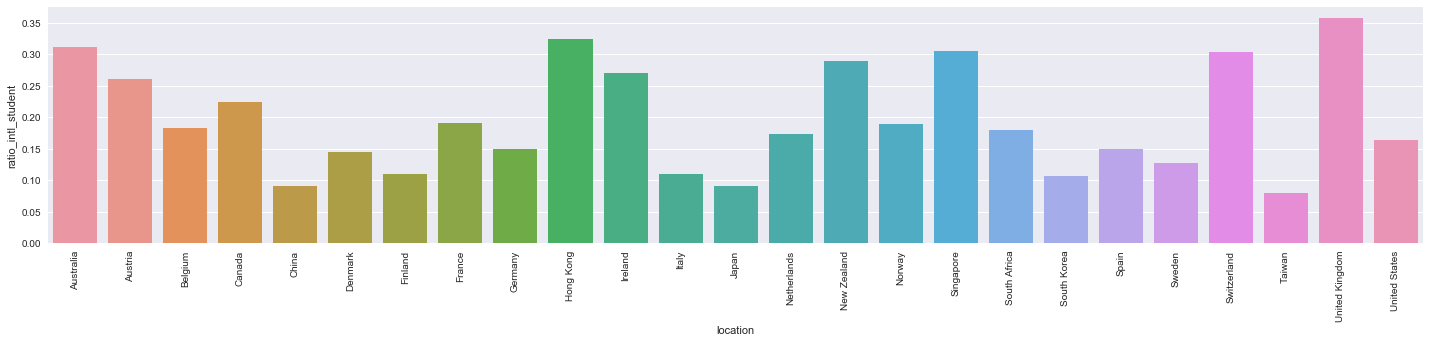

In [197]:
ax = sns.factorplot(kind = 'bar', x="location", y="ratio_intl_student", data=ranking_aggregated_country.reset_index(), aspect=5)
plt.xticks(rotation=90)
plt.show(ax)

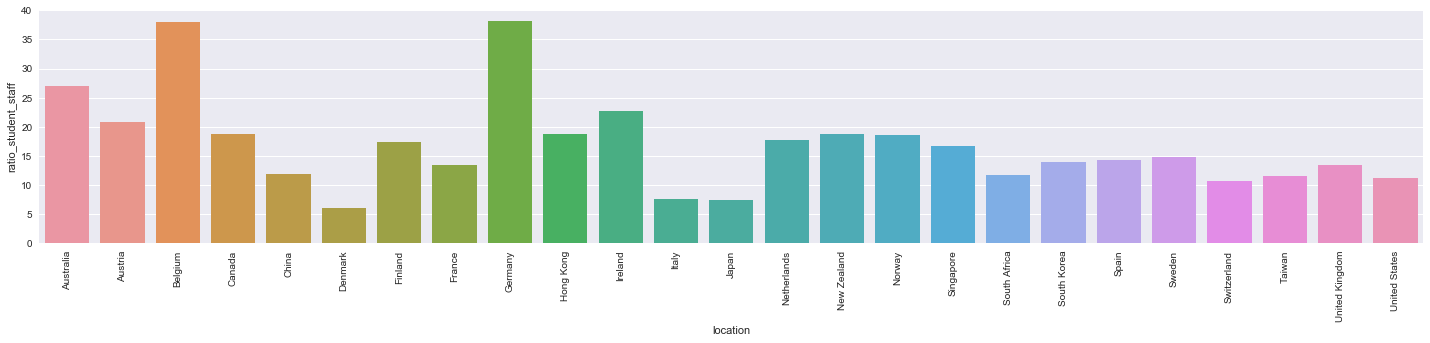

In [198]:
ax = sns.factorplot(kind = 'bar', x="location", y="ratio_student_staff", data=ranking_aggregated_country.reset_index(), aspect=5)
plt.xticks(rotation=90)
plt.show(ax)

And now aggregated by region: first sorted by ratio of international students and then by ratio of students to staff. We can see that Oceania has the highest international student ratio, while Latin America has the lowest ratio with only 1.5%. Also, Africa has the most students per staff while North America has the fewest.

In [199]:
ranking_aggregated_region = do_country_region_agg(ranking_extended_1, 'region', cols_list)
ranking_aggregated_region.sort_values(ascending=False, by='ratio_intl_student').head(20)

,num_staff,num_intl_students,stats_number_students,ratio_intl_student,ratio_student_staff
region,,,,,
Oceania,11554.291013,92612.57,298978.0,0.309764,25.875928
Europe,122518.727918,472314.66,2109418.0,0.223908,17.217107
Africa,1775.641026,3739.50,20775.0,0.180000,11.700000
North America,165590.114089,336270.47,1954934.0,0.172011,11.805862
Asia,42636.062289,78837.67,530949.0,0.148484,12.453050


In [200]:
ranking_aggregated_region.sort_values(ascending=False, by='ratio_student_staff').head(20)

,num_staff,num_intl_students,stats_number_students,ratio_intl_student,ratio_student_staff
region,,,,,
Oceania,11554.291013,92612.57,298978.0,0.309764,25.875928
Europe,122518.727918,472314.66,2109418.0,0.223908,17.217107
Asia,42636.062289,78837.67,530949.0,0.148484,12.453050
North America,165590.114089,336270.47,1954934.0,0.172011,11.805862
Africa,1775.641026,3739.50,20775.0,0.180000,11.700000


Bar charts follow:

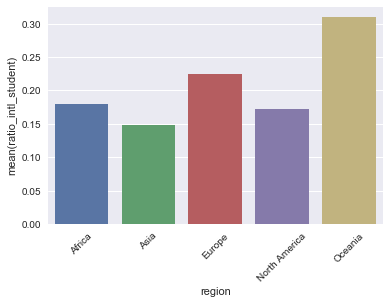

In [201]:
ax = sns.barplot(x="region", y="ratio_intl_student", data=ranking_aggregated_region.reset_index())
plt.xticks(rotation=45)
plt.show(ax)

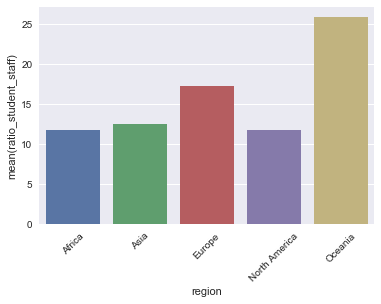

In [202]:
ax = sns.barplot(x="region", y="ratio_student_staff", data=ranking_aggregated_region.reset_index())
plt.xticks(rotation=45)
plt.show(ax)

- Ludwig-Maximilians-Universität München	
- Ruprecht-Karls-Universität Heidelberg	
- Université Pierre et Marie Curie (UPMC)
- Scuola Superiore Sant'Anna Pisa di Studi Universitari e di Perfezionamento

In [203]:
topunis_data["closest"]=topunis_data['name'].map(lambda x: difflib.get_close_matches(x, ranking_w_region["name"],n=1))

In [204]:
topunis_data["closest"]=topunis_data["closest"].apply(lambda x: x[0] if len(x)>0 else "")
topunis_data.loc[65,"closest"]="LMU Munich"
topunis_data.loc[67,"closest"]="Heidelberg University"
topunis_data.loc[130,"closest"]="Pierre and Marie Curie University"
topunis_data.loc[193,"closest"]="Scuola Superiore Sant’Anna"

In [206]:
pd.set_option('display.max_columns', 500)
merged_dataframes = pd.merge(ranking_w_region, topunis_data, left_on='name', right_on='closest')
merged_dataframes.shape
temp=pd.DataFrame()
merged_dataframes["academic reputation"]=merged_dataframes["academic reputation"].astype(float)
merged_dataframes["citations per faculty"]=merged_dataframes["citations per faculty"].astype(float)
merged_dataframes["employer reputation"]=merged_dataframes["employer reputation"].astype(float)
merged_dataframes["faculty-student"]=merged_dataframes["faculty-student"].astype(float)
merged_dataframes["internat students"]=merged_dataframes["internat students"].astype(float)
merged_dataframes["internat faculty"]=merged_dataframes["internat faculty"].astype(float)
#merged_dataframes[""]


/Users/odor/anaconda/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


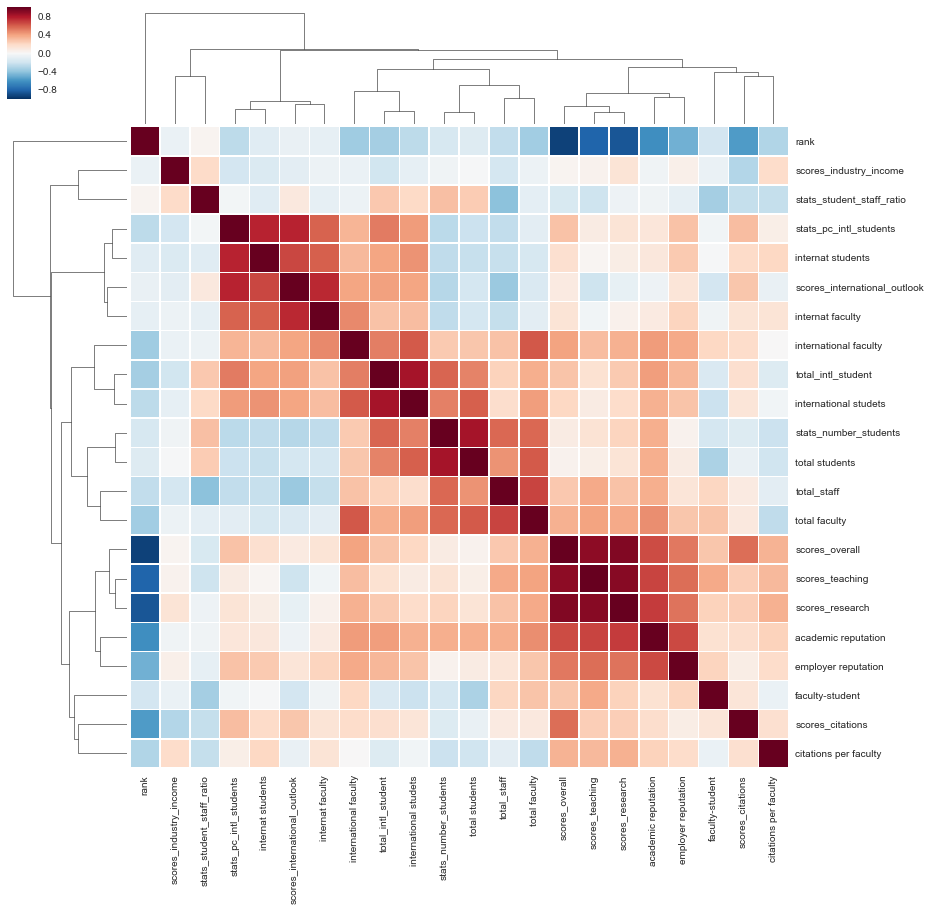

In [212]:
cg = sns.clustermap(merged_dataframes.corr(), linewidth=.5, figsize=(14,14))
plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);


In [172]:
tmp=pd.DataFrame()
tmp["x"]=[0, 1 ,2 , None]
tmp["y"]=[0,None,4,6]
tmp.corr()

,x,y
x,1.0,1.0
y,1.0,1.0
